In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install --user implicit
import implicit

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics.pairwise import pairwise_distances
from tqdm import tqdm

In [4]:
item = pd.read_csv('data/platform_content.csv')
consumer_interactions = pd.read_csv('data/consumer_transanctions.csv')

In [5]:
# One item has multiple rows
item['item_id'].value_counts()

-2990485643677949494    3
-1312850681127865433    2
 1433951803438448289    2
 8416004328454490172    2
-2377881752614744441    2
                       ..
 8857442213860272383    1
 7434270606888620096    1
 8095004770374551394    1
 6658257247913756761    1
-9166778629773133902    1
Name: item_id, Length: 3057, dtype: int64

In [6]:
item.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [7]:
consumer_interactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [8]:
consumer_interactions[~consumer_interactions['item_id'].isin(item['item_id'])]['item_id'].nunique()

0

**Inference**: There are 0 items which are available in customers interaction data but are not available in item dataset.

## Data pre-processing
rating: Generate Rating values based on the feature 'interaction type' with the highest weightage to content_followed, followed by content_commented_on, content saved, content liked and content_watched.

In [9]:
item['language'].value_counts()

en    2264
pt     850
la       4
es       2
ja       2
Name: language, dtype: int64

In [10]:
# Filtering content to only english language
item = item[item['language'] == 'en']

In [11]:
# There are 833 cunsumer interactions which are related to non english content.
consumer_interactions[~consumer_interactions['item_id'].isin(item['item_id'])]['item_id'].nunique()

833

In [12]:
consumer_interactions = consumer_interactions[consumer_interactions['item_id'].isin(item['item_id'])]

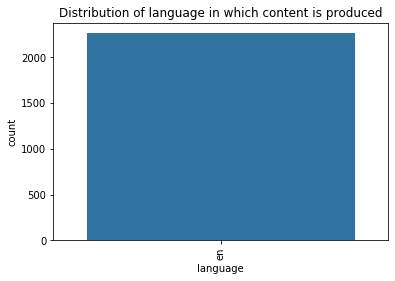

In [13]:
# Data Verification
sns.countplot(x= 'language', data=item)
plt.title('Distribution of language in which content is produced')
plt.xticks(rotation=90)
plt.show()

In [14]:
consumer_interactions['interaction_type'].value_counts()

content_watched         39848
content_liked            3431
content_saved            1847
content_commented_on     1038
content_followed          902
Name: interaction_type, dtype: int64

### Generating rating feature

In [15]:
def generateRating(val):
    if val == 'content_followed':
        return 5
    elif val == 'content_commented_on':
        return 4
    elif val == 'content_saved':
        return 3
    elif val == 'content_liked':
        return 2
    elif val == 'content_watched':
        return 1

In [16]:
consumer_interactions['rating'] = consumer_interactions['interaction_type'].apply(generateRating)

In [17]:
consumer_interactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,rating
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1
7,1465415066,content_watched,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1
9,1465413771,content_watched,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1


In [18]:
print(consumer_interactions.shape)
consumer_interactions.isnull().sum() / len(consumer_interactions) * 100

(47066, 9)


event_timestamp          0.000000
interaction_type         0.000000
item_id                  0.000000
consumer_id              0.000000
consumer_session_id      0.000000
consumer_device_info    21.629202
consumer_location       21.648324
country                 21.629202
rating                   0.000000
dtype: float64

In [19]:
print(item.shape)
item.isnull().sum() / len(item) * 100

(2264, 13)


event_timestamp          0.000000
interaction_type         0.000000
item_id                  0.000000
producer_id              0.000000
producer_session_id      0.000000
producer_device_info    79.107774
producer_location       79.107774
producer_country        79.107774
item_type                0.000000
item_url                 0.000000
title                    0.000000
text_description         0.000000
language                 0.000000
dtype: float64

## Exploratory data analysis
- Explore the various features present in the data set for their distribution and any meaningful inferences.
- Check the distribution of interaction type, consumer location/country, producer country/location, item type and so on.
- Check the most common language and most popular country that consumes the articles on the platform.

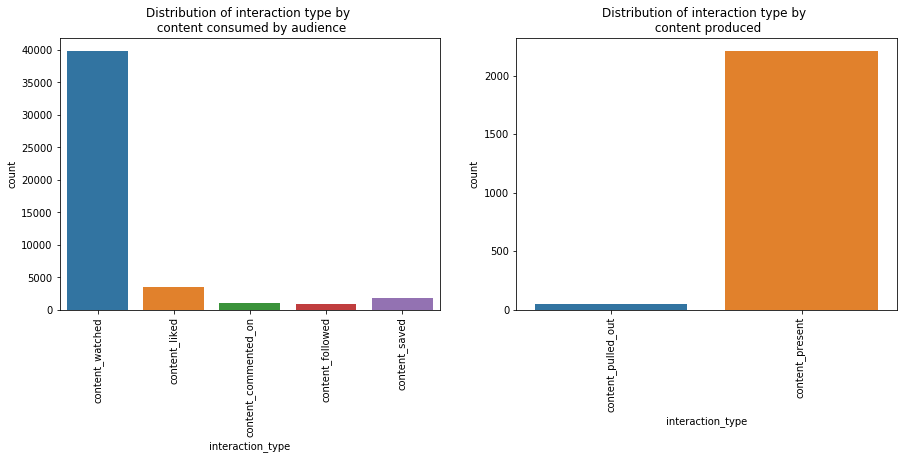

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x= 'interaction_type', data=consumer_interactions)
plt.title('Distribution of interaction type by \n content consumed by audience')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x= 'interaction_type', data=item)
plt.title('Distribution of interaction type by \n content produced')
plt.xticks(rotation=90)

plt.show()

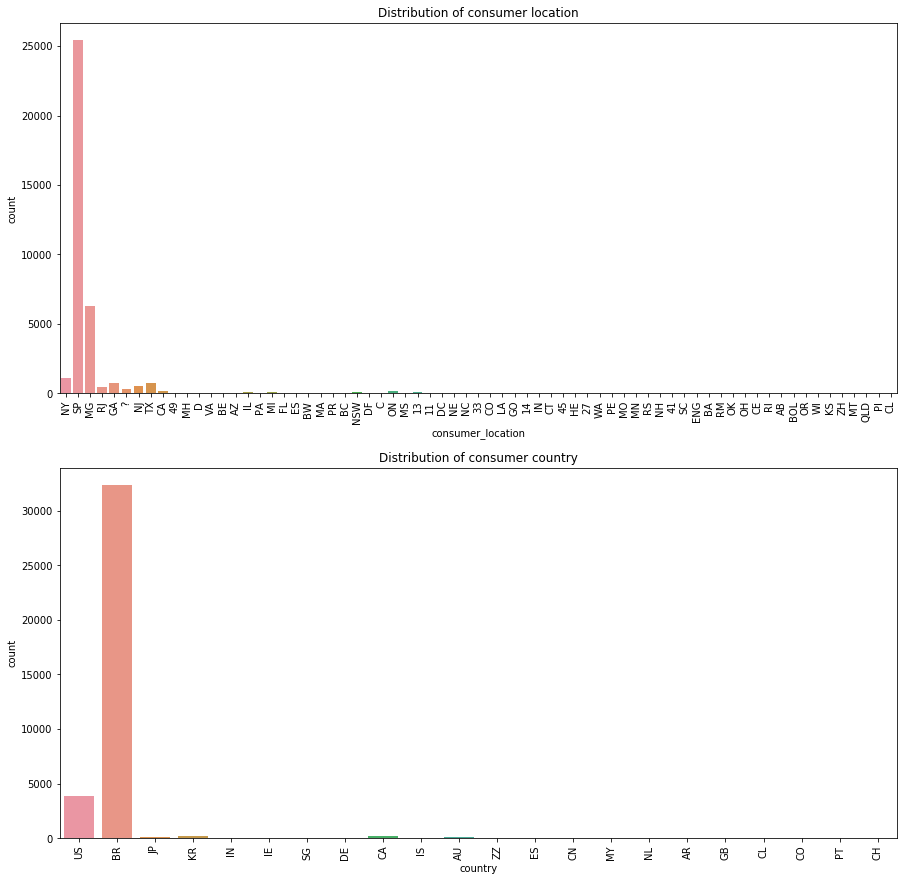

In [21]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.countplot(x= 'consumer_location', data=consumer_interactions)
plt.title('Distribution of consumer location')
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
sns.countplot(x= 'country', data=consumer_interactions)
plt.title('Distribution of consumer country')
plt.xticks(rotation=90)
plt.show()

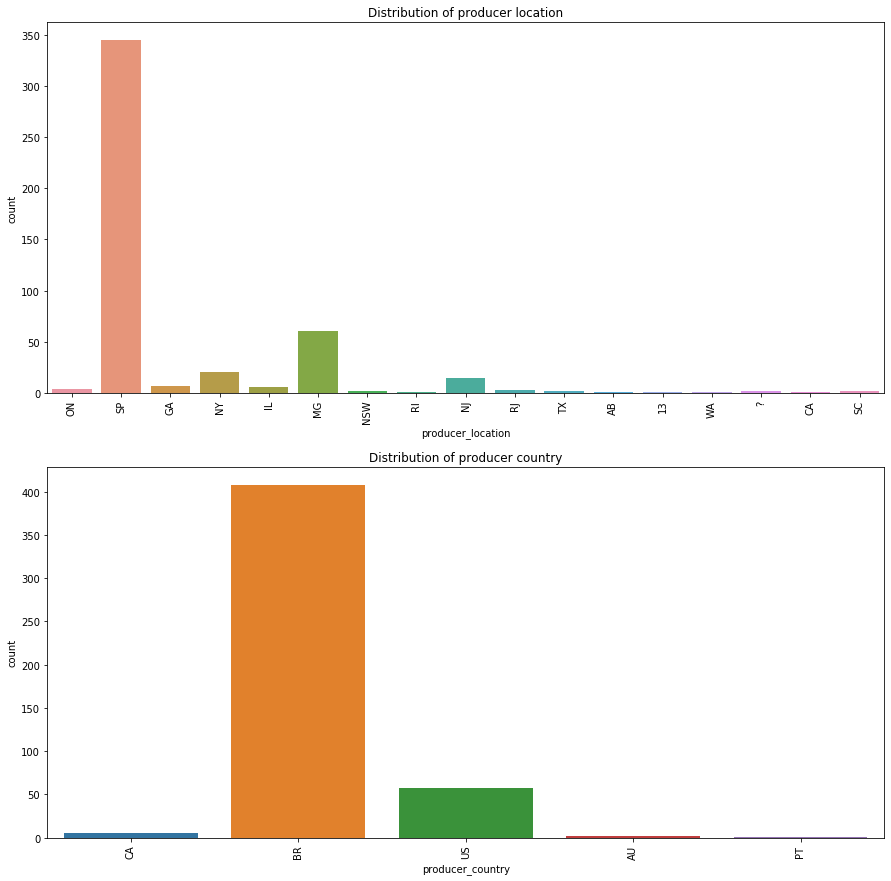

In [22]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
sns.countplot(x= 'producer_location', data=item)
plt.title('Distribution of producer location')
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
sns.countplot(x= 'producer_country', data=item)
plt.title('Distribution of producer country')
plt.xticks(rotation=90)

plt.show()

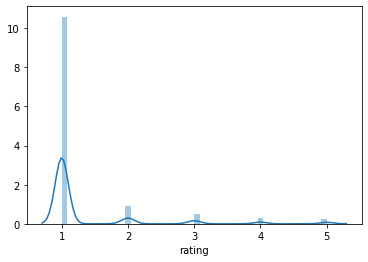

In [23]:
sns.distplot(consumer_interactions['rating'])
plt.show()

**Inference:** Most of users have watched the content but have not engaged with the content.

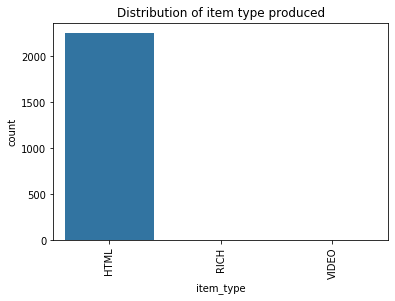

In [24]:
sns.countplot(x= 'item_type', data=item)
plt.title('Distribution of item type produced')
plt.xticks(rotation=90)
plt.show()

In [25]:
consumer_interactions['consumer_device_type'] = consumer_interactions['consumer_device_info'].str.split(' ', n=1, expand=True)[0]

In [26]:
# Verification that the percentage of missing value is same as that of 'consumer_device_info' column missing percentage
consumer_interactions['consumer_device_type'].isnull().sum() / len(consumer_interactions) * 100

21.62920154676412

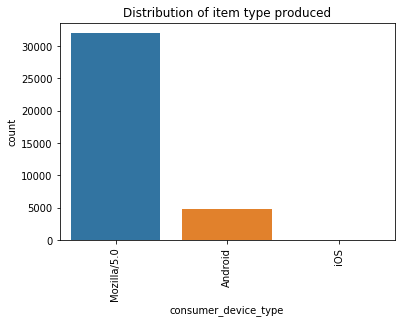

In [27]:
sns.countplot(x= 'consumer_device_type', data=consumer_interactions)
plt.title('Distribution of item type produced')
plt.xticks(rotation=90)
plt.show()

## Recommendation techniques
- Use the consumer_interaction data set for building the ALS, user-based and item-based collaborative filtering models
- Use platform_content data to build a content-based recommendation model

In [28]:
item.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [29]:
consumer_interactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,rating,consumer_device_type
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1,Mozilla/5.0
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1,NaN
7,1465415066,content_watched,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1,Mozilla/5.0
9,1465413771,content_watched,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1,NaN


In [30]:
item.producer_id.nunique()

188

In [31]:
n_items = consumer_interactions.item_id.nunique()
n_items, item.item_id.nunique()

(2154, 2218)

In [32]:
n_users = consumer_interactions.consumer_id.nunique()
n_users

1644

### Label Encoding consumer and item id

In [33]:
le_consumer_id = preprocessing.LabelEncoder()
le_consumer_id.fit(consumer_interactions['consumer_id'])
len(le_consumer_id.classes_)

1644

In [34]:
consumer_interactions['consumer_id_encoded'] = le_consumer_id.transform(consumer_interactions['consumer_id'])
consumer_interactions['consumer_id_encoded'].nunique()

1644

In [35]:
le_item_id = preprocessing.LabelEncoder()
le_item_id.fit(item['item_id'])
len(le_item_id.classes_)

2218

In [36]:
# There are few item ids which don't have any consumer interactions
consumer_interactions['item_id_encoded'] = le_item_id.transform(consumer_interactions['item_id'])
consumer_interactions['item_id_encoded'].nunique()

2154

In [37]:
item['item_id_encoded'] = le_item_id.transform(item['item_id'])
item['item_id_encoded'].nunique()

2218

In [38]:
consumer_interactions_op = consumer_interactions[['consumer_id_encoded', 'item_id_encoded', 'rating']]
consumer_interactions_op[:2]

,consumer_id_encoded,item_id_encoded,rating
0,32,701,1
1,732,2173,1


In [39]:
train , test = train_test_split(consumer_interactions_op, test_size=0.30, random_state=1)

In [40]:
print(consumer_interactions_op.shape)
print(train.shape)
print(test.shape)

(47066, 3)
(32946, 3)
(14120, 3)


### User-based collaborative filtering
- Create user-item matrix using the rating values.
- Find the user-similarity matrix based on a similarity measure.
- Generate predicted ratings for all the user-item pairs.

In [41]:
data_matrix_full = np.zeros((n_users, len(le_item_id.classes_)))
for line in consumer_interactions_op.itertuples():
    data_matrix_full[line[1], line[2]] = line[3]
data_matrix_full.shape

(1644, 2218)

= customers x items

In [42]:
data_matrix_train = np.zeros((n_users, len(le_item_id.classes_)))
for line in train.itertuples():
    data_matrix_train[line[1], line[2]] = line[3]
data_matrix_train.shape

(1644, 2218)

In [43]:
## Data Validation
train[train['consumer_id_encoded'] == 0].head()

,consumer_id_encoded,item_id_encoded,rating
51079,0,324,1
29363,0,610,1
21944,0,235,1
47158,0,1245,1
39274,0,1726,1


In [44]:
data_matrix_train[0][324], data_matrix_train[0][610]

(1.0, 1.0)

Validating that the data_matrix_train is updated correctly with the index values

In [45]:
# Creating test data
data_matrix_test = np.zeros((n_users, len(le_item_id.classes_)))
for line in test.itertuples():
    data_matrix_test[line[1], line[2]] = line[3]
data_matrix_test.shape

(1644, 2218)

In [46]:
user_similarity = 1 - pairwise_distances(data_matrix_train, metric='cosine')

In [47]:
user_similarity.shape

(1644, 1644)

= customer x customer

In [48]:
item_prediction = np.dot(user_similarity, data_matrix_test)
item_prediction.shape

(1644, 2218)

= customers x items

In [49]:
prediction_df = pd.DataFrame(item_prediction)
prediction_df.shape

(1644, 2218)

In [50]:
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217
0,0.671906,0.075184,0.159179,0.070205,0.191502,0.246908,0.0,0.0,0.146762,0.632160,...,0.109370,0.0,0.0,0.244538,0.141688,0.097717,0.384931,0.250110,0.435374,0.046596
1,0.370071,0.000000,0.232288,0.000000,0.089204,0.234452,0.0,0.0,0.000000,0.085424,...,0.051299,0.0,0.0,0.103744,0.000000,0.000000,0.087208,0.020998,0.136523,0.026688
2,1.104249,0.052223,0.071620,0.000000,0.000000,0.224774,0.0,0.0,0.434019,0.434501,...,0.000000,0.0,0.0,0.111803,0.034641,0.039528,0.324199,0.047553,0.122015,0.101274
3,0.127252,0.108471,0.000000,0.049088,0.000000,0.163014,0.0,0.0,0.204598,0.516175,...,0.000000,0.0,0.0,0.091237,0.083955,0.149071,0.187447,0.108448,0.111771,0.023870
4,0.253124,0.000000,0.104257,0.000000,0.000000,0.000000,0.0,0.0,0.046176,0.000000,...,0.000000,0.0,0.0,0.058926,0.000000,0.000000,0.127234,0.000000,0.299906,0.000000


#### Get recommendation for customer 300

In [51]:
selected_customer = 300

In [52]:
prediction_df.iloc[selected_customer].sort_values(ascending=False)[:10]

634     27.204617
34       5.672519
1945     3.789460
399      3.618643
517      3.106653
368      2.949130
2129     2.623776
134      2.609783
616      2.534788
1380     2.525679
Name: 300, dtype: float64

In [53]:
recommended_item_df = pd.DataFrame(prediction_df.iloc[selected_customer].sort_values(ascending=False))
recommended_item_df.reset_index(inplace=True)
recommended_item_df.columns = ['item_id', 'score']

In [54]:
recommended_item_df.head()

,item_id,score
0,634,27.204617
1,34,5.672519
2,1945,3.789460
3,399,3.618643
4,517,3.106653


## Creating general function to give score for any input customer

In [55]:
def get_user_based_collabarative_score(customer, records = 10):
    recommended_item_df = pd.DataFrame(prediction_df.iloc[selected_customer].sort_values(ascending=False))
    recommended_item_df.reset_index(inplace=True)
    recommended_item_df.columns = ['item_id', 'user_collabrative_score']
    return recommended_item_df.iloc[:records]

In [56]:
# Testing function
get_user_based_collabarative_score(customer=300, records=5)

,item_id,user_collabrative_score
0,634,27.204617
1,34,5.672519
2,1945,3.789460
3,399,3.618643
4,517,3.106653


In [57]:
cols = ['title', 'text_description', 'item_url', 'item_id_encoded']
merged = pd.merge(recommended_item_df, item[cols], left_on='item_id', right_on='item_id_encoded', how='left')

In [58]:
merged[merged['title'].notnull()].sort_values('score', ascending=False)[:10]

,item_id,score,title,text_description,item_url,item_id_encoded
0,634,27.204617,Former Google career coach shares a visual tri...,"If you want 2017 to be an exciting year, desig...",http://www.cnbc.com/2016/12/21/former-google-c...,634
1,34,5.672519,4 Reasons Managers Should Spend More Time on C...,There are managers who coach and managers who ...,https://hbr.org/2015/05/4-reasons-managers-sho...,34
2,1945,3.789460,"Life Coach vs. Therapist, Learn the Difference...",One of the most common misconceptions about li...,https://www.tonyrobbins.com/coaching/life-coac...,1945
3,399,3.618643,Promoting gender equality through emoji �� ��,More than 90 percent of the world's online pop...,https://googleblog.blogspot.com.br/2016/07/pro...,399
4,517,3.106653,Changing change management,Research tells us that most change efforts fai...,http://www.mckinsey.com/global-themes/leadersh...,517
5,368,2.949130,The Broken Window Theory,"In a previous entry , I touched on the broken ...",https://blog.codinghorror.com/the-broken-windo...,368
6,2129,2.623776,How to augment your career with leadership coa...,Burnout . Pipeline problems . Harassment . The...,http://www.cio.com/article/3047154/leadership-...,2129
7,134,2.609783,Ray Kurzweil: The world isn't getting worse - ...,"Ray Kurzweil, the author, inventor, computer s...",http://www.geekwire.com/2016/ray-kurzweil-worl...,134
8,616,2.534788,"[Situation Wall] Jamboard - the whiteboard, re...",Bringing the right team together for a meeting...,https://blog.google/products/g-suite/jamboard-...,616
9,1380,2.525679,10 Modern Software Over-Engineering Mistakes,10 Modern Software Over-Engineering Mistakes F...,https://medium.com/@rdsubhas/10-modern-softwar...,1380


### Evaluation

In [59]:
pred_set = merged['item_id'].values[:10]

In [60]:
selected_customer = 301
rating_filtered = consumer_interactions[(consumer_interactions['consumer_id_encoded'] == selected_customer) &
                     (consumer_interactions['rating'] > 2)].sort_values('rating', ascending=False)

In [61]:
rating_filtered

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,rating,consumer_device_type,consumer_id_encoded,item_id_encoded
6754,1464032696,content_followed,-3206777048078326150,-5823562314929634489,6054176641715856164,NaN,NaN,NaN,5,NaN,301,732
30456,1466625508,content_followed,-486686184692655504,-5823562314929634489,-1467398202818574571,NaN,NaN,NaN,5,NaN,301,1028
63684,1481558559,content_followed,7088167897470452815,-5823562314929634489,8765497782873839301,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,MG,BR,5,Mozilla/5.0,301,1945
67782,1486672774,content_followed,717471739656838182,-5823562314929634489,5850560069370184787,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,MG,BR,5,Mozilla/5.0,301,1168
30469,1466625508,content_commented_on,-486686184692655504,-5823562314929634489,-1467398202818574571,NaN,NaN,NaN,4,NaN,301,1028
63665,1481558559,content_commented_on,7088167897470452815,-5823562314929634489,8765497782873839301,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,MG,BR,4,Mozilla/5.0,301,1945
67784,1486672774,content_commented_on,717471739656838182,-5823562314929634489,5850560069370184787,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,MG,BR,4,Mozilla/5.0,301,1168


In [62]:
print(rating_filtered['item_id_encoded'].nunique())
relevant_set = rating_filtered['item_id_encoded'].values

4


In [63]:
pred_set

array([ 634,   34, 1945,  399,  517,  368, 2129,  134,  616, 1380])

In [64]:
list(set(relevant_set) & set(pred_set))

[1945]

In [65]:
percision_at_10 = len(list(set(relevant_set) & set(pred_set))) / 10
percision_at_10

0.1

In [66]:
n_users, n_items

(1644, 2154)

### Item-based collaborative filtering
- Find the item-similarity matrix based on a similarity measure.
- Generate the top 10 similar and relevant items based on the similarity scores.

In [67]:
# We can also use NearestNeighbors algorithm as well to find the similarity
item_similarity = 1 - pairwise_distances(data_matrix_full.T, metric='cosine')

In [68]:
# No of items is 3051, Therefore shape of our matrix is also the same.
item_similarity.shape

(2218, 2218)

= item x item

In [69]:
i_prediction = np.dot(item_similarity, data_matrix_test.T)
i_prediction.shape

(2218, 1644)

= item x customers

In [70]:
i_prediction_df = pd.DataFrame(i_prediction)
i_prediction_df.shape

(2218, 1644)

In [71]:
i_prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643
0,1.951921,0.262747,0.153398,0.148359,0.0,0.194444,0.348385,2.665946,0.0,1.431065,...,0.000000,2.925058,0.336804,0.063721,2.970808,0.656823,0.0,0.362978,0.651155,3.762653
1,0.571223,0.000000,0.100125,0.180054,0.0,0.117851,0.000000,0.176181,0.0,0.089803,...,0.000000,0.629420,0.062017,0.047036,0.000000,0.000000,0.0,0.050063,0.050063,0.000000
2,0.966594,0.134535,0.196362,0.163655,0.0,0.138675,0.312370,1.514332,0.0,1.326917,...,0.196116,1.871654,0.162980,0.106038,2.937299,0.341485,0.0,0.262798,0.671600,3.489735
3,0.488485,0.000000,0.086711,0.107211,0.0,0.000000,0.000000,0.000000,0.0,0.068041,...,0.000000,0.080938,0.000000,0.108625,0.205571,0.024225,0.0,0.043355,0.043355,0.650442
4,0.379958,0.085749,0.100125,0.000000,0.0,0.117851,0.150756,1.046766,0.0,0.766256,...,0.000000,1.951070,0.106600,0.047036,1.264855,0.828659,0.0,0.216729,0.525331,1.567907


In [72]:
selected_item = 2217

In [73]:
i_prediction_df.iloc[selected_item].sort_values(ascending=False)[:10]

732     33.430158
524     30.592024
879     25.976762
704     24.401964
1154    15.751322
1050    15.519047
606     13.500323
1175    10.372857
1389     9.234418
1158     8.721925
Name: 2217, dtype: float64

In [74]:
recommended_item_df_i = pd.DataFrame(i_prediction_df.iloc[selected_item].sort_values(ascending=False))
recommended_item_df_i.reset_index(inplace=True)
recommended_item_df_i.columns = ['item_id', 'score']

In [75]:
def get_item_based_collabarative_score(item, records = 10):
    recommended_item_df_i = pd.DataFrame(i_prediction_df.iloc[selected_item].sort_values(ascending=False))
    recommended_item_df_i.reset_index(inplace=True)
    recommended_item_df_i.columns = ['item_id', 'item_collabrative_score']
    return recommended_item_df_i.iloc[:records]

In [76]:
get_item_based_collabarative_score(item=2217, records=5)

,item_id,item_collabrative_score
0,732,33.430158
1,524,30.592024
2,879,25.976762
3,704,24.401964
4,1154,15.751322


In [77]:
cols = ['item_id_encoded', 'title']
merged_i = pd.merge(recommended_item_df_i, item[cols], left_on='item_id', right_on='item_id_encoded', how='left')

In [78]:
merged_i.shape

(1675, 4)

In [79]:
collated_output = merged_i[merged_i['title'].notna()]

In [80]:
collated_output.shape

(1675, 4)

In [81]:
collated_output.head()

,item_id,score,item_id_encoded,title
0,732,33.430158,732,Google IO 2016: A look at how not to run a lar...
1,524,30.592024,524,Algorithms and architecture for job recommenda...
2,879,25.976762,879,The Spotify Tribe
3,879,25.976762,879,The Spotify Tribe
4,704,24.401964,704,AEM 6.1 Package Manager Metadata Files


### Min Max Normalization

In [82]:
collated_output['item_collabarative_score_normalized'] = (collated_output['score'] - min(collated_output['score'])) / (max(collated_output['score']) - min(collated_output['score']))

In [83]:
collated_output.head()

,item_id,score,item_id_encoded,title,item_collabarative_score_normalized
0,732,33.430158,732,Google IO 2016: A look at how not to run a lar...,1.000000
1,524,30.592024,524,Algorithms and architecture for job recommenda...,0.915103
2,879,25.976762,879,The Spotify Tribe,0.777046
3,879,25.976762,879,The Spotify Tribe,0.777046
4,704,24.401964,704,AEM 6.1 Package Manager Metadata Files,0.729939


### Content-based filtering
- Use text processing to analyse the ‘keywords’ feature in the data set.
- Recommend similar items based on the TF-IDF scores.

In [84]:
item.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language,item_id_encoded
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,338
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,624
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,238
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,369
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,1359


In [85]:
np.mean(item['text_description'].str.len())

6071.933745583039

In [86]:
num_of_keywords = []
for keyword in item['text_description']:
    n_words = len(keyword.split(' '))
    num_of_keywords.append(n_words)

In [87]:
num_of_keywords[:10]

[1072, 1072, 311, 272, 1354, 276, 689, 727, 1689, 782]

In [88]:
sum(num_of_keywords)

2276113

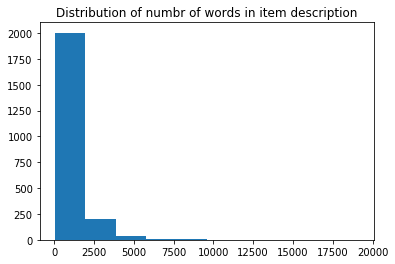

In [89]:
plt.hist(num_of_keywords)
plt.title('Distribution of numbr of words in item description')
plt.show()

In [90]:
item_c = item[['title', 'text_description', 'item_id_encoded']].drop_duplicates()
item_c.shape

(2220, 3)

In [91]:
# Removed two duplicate rows
item_c = item_c[~item_c.item_id_encoded.duplicated(keep='first')]
item_c.shape

(2218, 3)

In [92]:
item_c.head()

,title,text_description,item_id_encoded
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,338
1,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,624
2,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,238
3,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,369
4,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,1359


In [93]:
desc_array = item_c['text_description'].to_numpy()

In [94]:
desc_array[0]

'All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azure. "Et

In [95]:
word_list = []
for keyword in desc_array:
    words = keyword.lower().split(' ')
    word_list.append(words)

In [96]:
word_list[0]

['all',
 'of',
 'this',
 'work',
 'is',
 'still',
 'very',
 'early.',
 'the',
 'first',
 'full',
 'public',
 'version',
 'of',
 'the',
 'ethereum',
 'software',
 'was',
 'recently',
 'released,',
 'and',
 'the',
 'system',
 'could',
 'face',
 'some',
 'of',
 'the',
 'same',
 'technical',
 'and',
 'legal',
 'problems',
 'that',
 'have',
 'tarnished',
 'bitcoin.',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'will',
 'face',
 'more',
 'security',
 'problems',
 'than',
 'bitcoin',
 'because',
 'of',
 'the',
 'greater',
 'complexity',
 'of',
 'the',
 'software.',
 'thus',
 'far,',
 'ethereum',
 'has',
 'faced',
 'much',
 'less',
 'testing,',
 'and',
 'many',
 'fewer',
 'attacks,',
 'than',
 'bitcoin.',
 'the',
 'novel',
 'design',
 'of',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'by',
 'authorities',
 'given',
 'that',
 'potentially',
 'fraudulent',
 'contracts,',
 'like',
 'the',
 'ponzi',
 'schemes,',
 'can',
 'be',
 'written',
 'directly',
 'into',
 

In [97]:
from gensim.corpora.dictionary import Dictionary

In [98]:
dictionary = Dictionary(word_list)

In [99]:
len(dictionary)

113948

In [100]:
dictionary.get(500)

'winning'

#### Generating Bag of words

In [101]:
bow = dictionary.doc2bow(word_list[0])

In [102]:
bow[:10]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [103]:
corpus = [dictionary.doc2bow(doc) for doc in word_list]

#### Generating TF-IDF Model

In [104]:
from gensim.models.tfidfmodel import TfidfModel

In [105]:
tfidf = TfidfModel(corpus)

In [106]:
tfidf[corpus[0]]

[(0, 0.013416569222082286),
 (1, 0.01980536990078569),
 (2, 0.08229415056771741),
 (3, 0.04733299135629694),
 (4, 0.04733299135629694),
 (5, 0.04043645180743467),
 (6, 0.04459567988755705),
 (7, 0.025468541140014987),
 (8, 0.041147075283858706),
 (9, 0.03991621502380035),
 (10, 0.042653526492540256),
 (11, 0.03646761042010202),
 (12, 0.03991621502380035),
 (13, 0.0035343721552064692),
 (14, 0.04619376436694535),
 (15, 0.01254290978997721),
 (16, 0.02727960224606609),
 (17, 0.030016913714805988),
 (18, 0.020789076276258298),
 (19, 0.04459567988755705),
 (20, 0.04459567988755705),
 (21, 0.0180517648075184),
 (22, 0.04459567988755705),
 (23, 0.004315968996538433),
 (24, 0.005435112034872729),
 (25, 0.01610961141250161),
 (26, 0.03419607263843398),
 (27, 0.020376526837493067),
 (28, 0.025082662358807174),
 (29, 0.03249943869130376),
 (30, 0.021785772920801395),
 (31, 0.00873536423328901),
 (32, 0.016043747077852482),
 (33, 0.0217490367429973),
 (34, 0.007706932799632549),
 (35, 0.044595679

#### Generating Similarity Matrix

In [107]:
from gensim.similarities import MatrixSimilarity

In [108]:
sim = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [109]:
item_id_encoded = 481
# No of recommendation
n = 5

In [110]:
item_r = item_c.loc[item_c['item_id_encoded'] == item_id_encoded]

In [111]:
item_r

,title,text_description,item_id_encoded
1218,Introducing Google Container Engine (GKE) node...,"Editor's note: Updated May 27, 2016 with guida...",481


In [157]:
def get_content_based_score(item, records=5):
    item_r = item_c.loc[item_c['item_id_encoded'] == item]
    
    words = item_r['text_description'].iloc[0].lower().split(' ')
    query_doc = words
    
    query_doc_bow = dictionary.doc2bow(query_doc)
    query_doc_tfidf = tfidf[query_doc_bow]
    
    similarity_array = sim[query_doc_tfidf]
    
    similarity_series = pd.Series(similarity_array, index=item_c['item_id_encoded'].values)
    recommended_items = similarity_series.sort_values(ascending=False)[1:records+1]
    recommended_items = recommended_items.reset_index()
    recommended_items.columns = ['item_id', 'item_content_score']
#     recommended_items = pd.merge(recommended_items, item_c, on='item_id_encoded', how='left')
    return recommended_items

In [158]:
get_content_based_score(754, 5)

,item_id,item_content_score
0,754,1.000000
1,1944,1.000000
2,1845,0.919152
3,665,0.096688
4,638,0.084441


### ALS
- Create Compressed Sparse user-item and item-user matrices. 
- Train the ALS model and generate recommendations for a user. Try experimenting with the hyperparameters.

In [114]:
from scipy.sparse import csr_matrix

In [115]:
alpha = 40

In [116]:
consumer_interactions_als = consumer_interactions[['consumer_id_encoded', 'item_id_encoded', 'rating']]
sparse_user_item = csr_matrix( ([alpha] * consumer_interactions_als.shape[0], (consumer_interactions_als['consumer_id_encoded'],
                                                consumer_interactions_als['item_id_encoded']) ))

In [117]:
print(sparse_user_item[:1])

  (0, 113)	40
  (0, 134)	40
  (0, 141)	40
  (0, 235)	40
  (0, 277)	40
  (0, 298)	40
  (0, 322)	80
  (0, 324)	80
  (0, 335)	40
  (0, 416)	40
  (0, 517)	80
  (0, 573)	40
  (0, 610)	80
  (0, 650)	40
  (0, 671)	40
  (0, 1182)	40
  (0, 1190)	40
  (0, 1245)	40
  (0, 1252)	80
  (0, 1605)	80
  (0, 1620)	40
  (0, 1710)	40
  (0, 1726)	40
  (0, 1960)	40
  (0, 2004)	40
  (0, 2099)	120
  (0, 2100)	40
  (0, 2183)	80


In [118]:
# Creating user-item sparse matrix
csr_user_array = sparse_user_item.toarray()

In [119]:
len(csr_user_array), len(csr_user_array[0]), csr_user_array[2][1]

(1644, 2218, 0)

In [120]:
# Creating item-user sparse matrix
sparse_item_user = sparse_user_item.T.tocsr()

In [121]:
csr_item_array = sparse_item_user.toarray()

In [122]:
train, test = train_test_split(sparse_item_user, test_size=0.2)

In [123]:
train

<1774x1644 sparse matrix of type '<class 'numpy.longlong'>'
	with 20729 stored elements in Compressed Sparse Row format>

#### Building ALS Model

In [124]:
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, calculate_training_loss=False)

In [125]:
model

In [126]:
model.fit(train)

HBox(children=(FloatProgress(value=0.0, max=20.0), HTML(value='')))

#### Generating recommendation for user id

In [127]:
user_id = 33

In [128]:
output = model.recommend(user_id, sparse_user_item, N=5)
output

[(606, 1.0233341),
 (1206, 0.99704814),
 (15, 0.99095124),
 (1376, 0.98479986),
 (18, 0.9837043)]

In [129]:
output_df = pd.DataFrame(output,  columns=['item_id', 'als_score'])
output_df.head()

,item_id,als_score
0,606,1.023334
1,1206,0.997048
2,15,0.990951
3,1376,0.984800
4,18,0.983704


In [130]:
def als_user_based_score(customer, records=5):
    output = model.recommend(user_id, sparse_user_item, N=records)
    output_df = pd.DataFrame(output,  columns=['item_id', 'user_als_score'])
    return output_df

In [131]:
als_user_based_score(customer=33,records=5)

,item_id,user_als_score
0,606,1.023334
1,1206,0.997048
2,15,0.990951
3,1376,0.984800
4,18,0.983704


In [132]:
merged = pd.merge(output_df, item_c, how='left', left_on='item_id', right_on='item_id_encoded')
merged.head()

,item_id,als_score,title,text_description,item_id_encoded
0,606,1.023334,Could Iceland Embrace Crypto Before Anyone Else?,It has been a rough decade for Iceland . Betwe...,606
1,1206,0.997048,DARPA Wants to Give Radio Waves AI to Stretch ...,Image by elBidule The radio spectrum is a mess...,1206
2,15,0.990951,OpenBazaar is Open for Business,OpenBazaar is now released on the mainnet and ...,15
3,1376,0.984800,What Business Leaders Should Know About Swift,"If you're interested in mobile, it's likely th...",1376
4,18,0.983704,Drupal How-To: Responsive or Adaptive Images? ...,"In this 3-part Drupal How-To series, I'm going...",18


#### Generating recommendation for item id

In [133]:
item_id = 1296

In [134]:
output_item = model.similar_items(item_id, N=5)
output_item

[(1296, 1.0),
 (685, 0.6744623),
 (1469, 0.669645),
 (317, 0.62417555),
 (813, 0.59576404)]

In [135]:
output_df_item = pd.DataFrame(output,  columns=['item_id', 'als_score'])
output_df_item.head()

,item_id,als_score
0,606,1.023334
1,1206,0.997048
2,15,0.990951
3,1376,0.984800
4,18,0.983704


In [136]:
def als_item_based_score(item, records=5):
    output_item = model.similar_items(item_id, N=records)
    output_df_item = pd.DataFrame(output,  columns=['item_id', 'item_als_score'])
    return output_df_item

In [137]:
als_item_based_score(item=1, records=n_users)

,item_id,item_als_score
0,606,1.023334
1,1206,0.997048
2,15,0.990951
3,1376,0.984800
4,18,0.983704


In [138]:
merged_item = pd.merge(output_df, item_c, how='left', left_on='item_id', right_on='item_id_encoded')
merged_item.head()

,item_id,als_score,title,text_description,item_id_encoded
0,606,1.023334,Could Iceland Embrace Crypto Before Anyone Else?,It has been a rough decade for Iceland . Betwe...,606
1,1206,0.997048,DARPA Wants to Give Radio Waves AI to Stretch ...,Image by elBidule The radio spectrum is a mess...,1206
2,15,0.990951,OpenBazaar is Open for Business,OpenBazaar is now released on the mainnet and ...,15
3,1376,0.984800,What Business Leaders Should Know About Swift,"If you're interested in mobile, it's likely th...",1376
4,18,0.983704,Drupal How-To: Responsive or Adaptive Images? ...,"In this 3-part Drupal How-To series, I'm going...",18


### Hybrid recommendation system
- Normalise the scores for content and collaborative filtering and combine them with an appropriate weightage to build a hybrid model.
- Try out hybrids of different types of models that can help recommend items similar to a particular item. For example, Content+Item-based collaborative model, ALS+Item-based collaborative model, ALS+Content-based model, etc.

In [139]:
CUSTOMER = 300
ITEM = 2217

#### Customer based recommendations

In [140]:
df_hybrid_user = pd.DataFrame(columns=['user_id', 'item_id', 'user_collabrative_score', 'user_als_score'])
df_hybrid_user.head()

,user_id,item_id,user_collabrative_score,user_als_score


In [141]:
df_hybrid_user = pd.DataFrame()
for user_index in tqdm(range(0, n_users)):
    df_user_collabrative = get_user_based_collabarative_score(customer=user_index, records=n_items)
    df_user_als = als_user_based_score(customer=user_index,records=n_items)
    df = pd.merge(df_user_collabrative, df_user_als, on='item_id', how='left')
    df['user_id'] = user_index
    df_hybrid_user = df_hybrid_user.append(df)

100%|██████████| 1644/1644 [01:24<00:00, 19.55it/s]


In [142]:
n_users, df_hybrid_user['user_id'].nunique()

(1644, 1644)

In [143]:
df_hybrid_user['hybrid_user_score'] = df_hybrid_user[['user_collabrative_score', 'user_als_score']].mean(axis=1)

In [144]:
df_hybrid_user.head()

,item_id,user_collabrative_score,user_als_score,user_id,hybrid_user_score
0,634,6.940899,0.000000,0,3.470449
1,1945,4.886245,NaN,0,4.886245
2,1960,2.841096,NaN,0,2.841096
3,1915,2.787629,NaN,0,2.787629
4,327,2.756232,-0.052737,0,1.351748


In [159]:
df_hybrid_items = pd.DataFrame(columns=['selected_item_id', 'item_id', 'item_collabrative_score', 'item_content_score',
                                        'item_als_score'])

In [160]:
df_hybrid_items = pd.DataFrame()
for item_index in tqdm(range(0, n_items)):
    df_item_collabrative = get_item_based_collabarative_score(item=item_index, records=n_items)
    df_item_content = get_content_based_score(item=item_index, records=n_items)
    df_item_als = als_item_based_score(item=item_index, records=n_users)
    
    df_t = pd.merge(df_item_content, df_item_als, on='item_id', how='left')
    df = pd.merge(df_t, df_item_collabrative, on='item_id', how='left')
    df['selected_item_id'] = item_index
    df_hybrid_items = df_hybrid_items.append(df)

100%|██████████| 2154/2154 [03:35<00:00,  9.98it/s]


In [162]:
n_items, df_hybrid_items['item_id'].nunique(), df_hybrid_items['selected_item_id'].nunique()

(2154, 2218, 2154)

In [163]:
df_hybrid_items['hybrid_item_score'] = df_hybrid_items[['item_content_score', 'item_als_score',
                                                     'item_collabrative_score']].mean(axis=1)

In [164]:
df_hybrid_items.head()

,item_id,item_content_score,item_als_score,item_collabrative_score,selected_item_id,hybrid_item_score
0,1577,0.195474,NaN,0.488893,0,0.342183
1,2001,0.194582,NaN,NaN,0,0.194582
2,1019,0.190934,NaN,0.000000,0,0.095467
3,1290,0.179470,NaN,0.079057,0,0.129264
4,1416,0.164709,NaN,0.000000,0,0.082355


## Model evaluation
- Use appropriate evaluation metrics, such as RMSE, MAE and precision@k
- Use global precision@k to assess the overall performance of the recommendation system.

#### Global Average Precision@K

In [165]:
# Evaluationg hybrid user model
df_hybrid_user.head()

,item_id,user_collabrative_score,user_als_score,user_id,hybrid_user_score
0,634,6.940899,0.000000,0,3.470449
1,1945,4.886245,NaN,0,4.886245
2,1960,2.841096,NaN,0,2.841096
3,1915,2.787629,NaN,0,2.787629
4,327,2.756232,-0.052737,0,1.351748


In [166]:
global_percision = 0
for user_index in tqdm(range(0, n_users)):
    user_relevant_set = consumer_interactions[(consumer_interactions['consumer_id_encoded'] == user_index) &
                (consumer_interactions['rating'] > 2)].sort_values('rating', ascending=False)['item_id_encoded'].tolist()
    user_predicted_set = df_hybrid_user[df_hybrid_user['user_id'] == user_index
                        ].sort_values('hybrid_user_score', ascending=False)[:10].index.tolist()
    percision_at_10 = len(list(set(user_relevant_set) & set(user_predicted_set))) / 10
#     print(percision_at_10)
    global_percision = global_percision + percision_at_10
print(global_percision)

100%|██████████| 1644/1644 [00:08<00:00, 200.56it/s]

0.9999999999999999


In [167]:
### Global Average Precision
global_average_percision = global_percision / n_users
global_average_percision

0.000608272506082725

#### Don't recommend items that user have already read

In [168]:
selected_customer = 410
df_user = pd.DataFrame(data_matrix_full[selected_customer], columns=['rating'])
df_user.reset_index(inplace=True)
df_user.columns = ['item_id', 'rating']
df_user.head()

,item_id,rating
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [169]:
df_user['rating'].value_counts()

0.0    2217
1.0       1
Name: rating, dtype: int64

In [170]:
cols = ['user_id', 'item_id', 'hybrid_user_score']
merged_collab = pd.merge(df_hybrid_user[df_hybrid_user['user_id'] == selected_customer][cols], df_user, on='item_id', how='left')
merged_collab.head()

,user_id,item_id,hybrid_user_score,rating
0,410,634,3.470449,0.0
1,410,1945,4.886245,0.0
2,410,1960,2.841096,0.0
3,410,1915,2.787629,0.0
4,410,327,1.351748,0.0


In [171]:
merged_collab = merged_collab.drop(merged_collab[merged_collab['rating'] > 0].index)
merged_collab.head()

,user_id,item_id,hybrid_user_score,rating
0,410,634,3.470449,0.0
1,410,1945,4.886245,0.0
2,410,1960,2.841096,0.0
3,410,1915,2.787629,0.0
4,410,327,1.351748,0.0


In [172]:
merged_collab.shape

(2153, 4)

In [174]:
merged_collab[merged_collab['rating'].notnull()].sort_values('hybrid_user_score', ascending=False)['item_id'][:10].to_list()

[1945, 634, 1960, 1915, 2078, 2142, 134, 383, 2196, 1868]

`Inference: ` Recommended top 10 items for the ${selected_customer}